# Анализ клиентов фитнес клуба

###### Требуется провести анализ и подготовить план действий по удержанию клиентов

###### Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:
Данные клиента за предыдущий до проверки факта оттока месяц:
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from scipy import stats
import plotly.express as px
import re
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = None

## Загрузка данных

In [2]:
try:
    gym_churn = pd.read_csv('/datasets/gym_churn.csv', sep=',')
except:
    gym_churn = pd.read_csv('gym_churn.csv')

In [3]:
print('Размер датасета:', gym_churn.shape)
gym_churn.head()

Размер датасета: (4000, 14)


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


## исследовательский анализ данных (EDA)

In [4]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [5]:
# проверка на пропуски
gym_churn.isna().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

In [6]:
# проверка на дупликаты
gym_churn.duplicated().sum()

0

In [7]:
gym_churn.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


In [8]:
gym_churn.groupby('Churn').describe()

gender                                    Near_Location            \
         count mean  std  min  25%  50%  75%  max         count mean  std   
Churn                                                                       
0     2,939.00 0.51 0.50 0.00 0.00 1.00 1.00 1.00      2,939.00 0.87 0.33   
1     1,061.00 0.51 0.50 0.00 0.00 1.00 1.00 1.00      1,061.00 0.77 0.42   

                                Partner                                     \
       min  25%  50%  75%  max    count mean  std  min  25%  50%  75%  max   
Churn                                                                        
0     0.00 1.00 1.00 1.00 1.00 2,939.00 0.53 0.50 0.00 0.00 1.00 1.00 1.00   
1     0.00 1.00 1.00 1.00 1.00 1,061.00 0.36 0.48 0.00 0.00 0.00 1.00 1.00   

      Promo_friends                                       Phone            \
              count mean  std  min  25%  50%  75%  max    count mean  std   
Churn                                                                       
0          2,939.00 0.35 0.48 0.00 0.00 0.00 1.00 1.00 2,939.00 0.90 0.30   
1          1,061.00 0.18 0.39 0.00 0.00 0.00 0.00 1.00 1,061.00 0.90 0.30   

                               Contract_period                                 \
       min  25%  50%  75%  max           count mean  std  min  25%  50%   75%   
Churn                                                                           
0     0.00 1.00 1.00 1.00 1.00        2,939.00 5.75 4.72 1.00 1.00 6.00 12.00   
1     0.00 1.00 1.00 1.00 1.00        1,061.00 1.73 2.13 1.00 1.00 1.00  1.00   

            Group_visits                                         Age        \
        max        count mean  std  min  25%  50%  75%  max    count  mean   
Churn                                                                        
0     12.00     2,939.00 0.46 0.50 0.00 0.00 0.00 1.00 1.00 2,939.00 29.98   
1     12.00     1,061.00 0.27 0.44 0.00 0.00 0.00 1.00 1.00 1,061.00 26.99   

                                         Avg_additional_charges_total         \
       std   min   25%   50%   75%   max                        count   mean   
Churn                                                                          
0     3.01 19.00 28.00 30.00 32.00 41.00                     2,939.00 158.45   
1     2.90 18.00 25.00 27.00 29.00 38.00                     1,061.00 115.08   

                                            Month_to_end_contract            \
        std  min   25%    50%    75%    max                 count mean  std   
Churn                                                                         
0     99.80 0.17 76.92 149.88 224.45 552.59              2,939.00 5.28 4.36   
1     77.70 0.15 50.63 103.81 165.62 425.54              1,061.00 1.66 1.96   

                                 Lifetime                                      \
       min  25%  50%   75%   max    count mean  std  min  25%  50%  75%   max   
Churn                                                                           
0     1.00 1.00 6.00 10.00 12.00 2,939.00 4.71 3.87 0.00 2.00 4.00 6.00 31.00   
1     1.00 1.00 1.00  1.00 12.00 1,061.00 0.99 1.11 0.00 0.00 1.00 1.00  9.00   

      Avg_class_frequency_total                                     \
                          count mean  std  min  25%  50%  75%  max   
Churn                                                                
0                      2,939.00 2.02 1.02 0.00 1.28 2.04 2.73 6.02   
1                      1,061.00 1.47 0.69 0.00 1.01 1.49 1.96 3.48   

      Avg_class_frequency_current_month                                     
                                  count mean  std  min  25%  50%  75%  max  
Churn                                                                       
0                              2,939.00 2.03 1.02 0.00 1.30 2.05 2.74 6.15  
1                              1,061.00 1.04 0.77 0.00 0.42 0.98 1.59 3.54

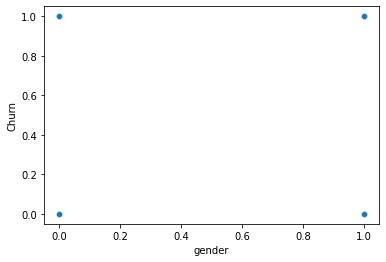

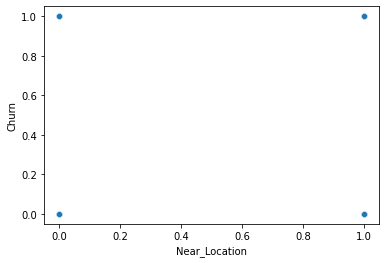

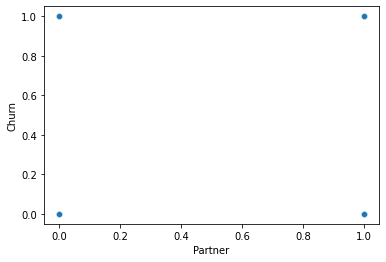

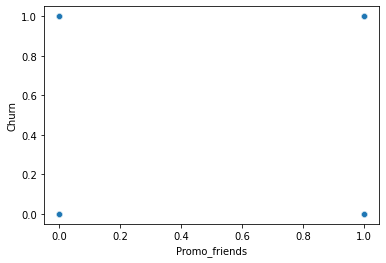

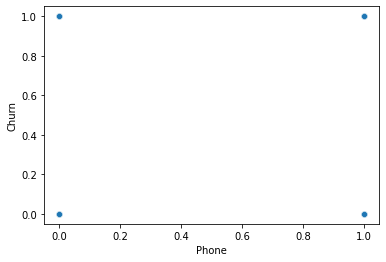

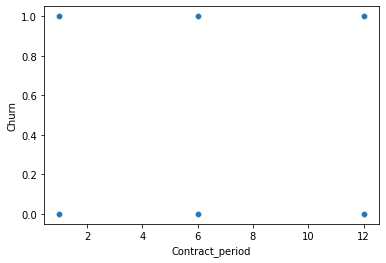

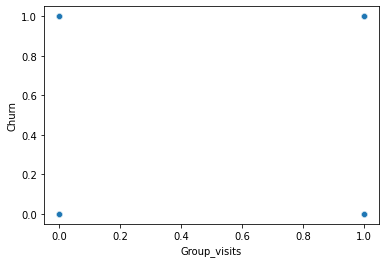

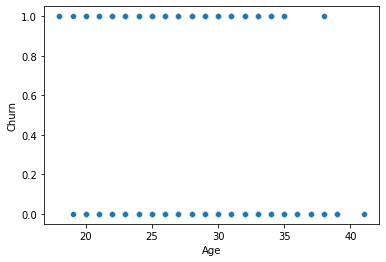

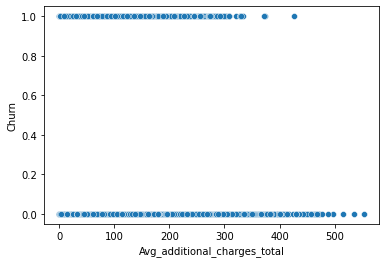

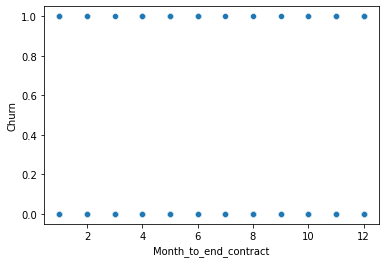

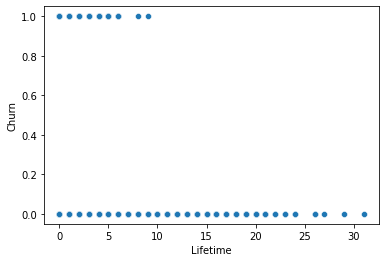

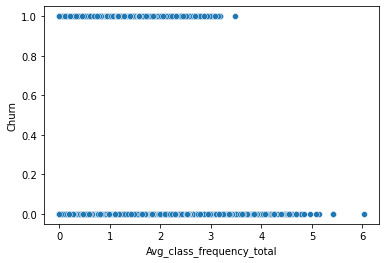

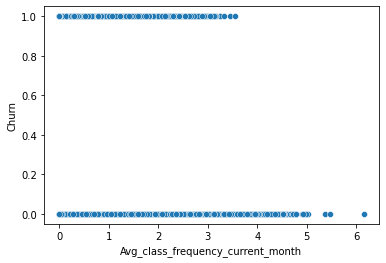

In [9]:
#построим попарные диаграммы рассеяния признак-целевая переменная для каждого признака
for col in gym_churn.drop('Churn', axis = 1).columns:
    sns.scatterplot(x=gym_churn[col], y=gym_churn['Churn'])
    plt.show()

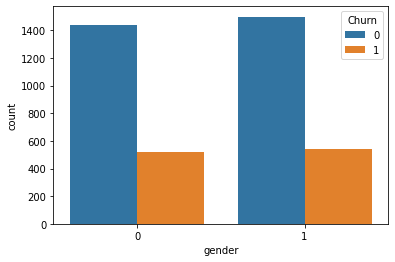

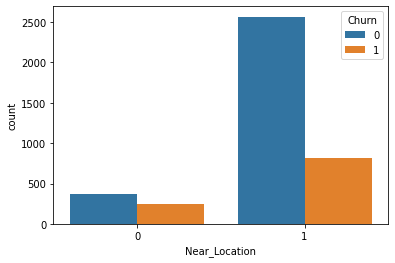

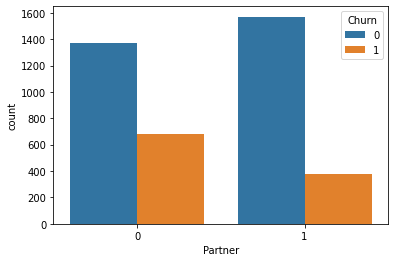

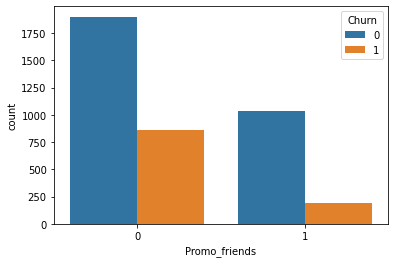

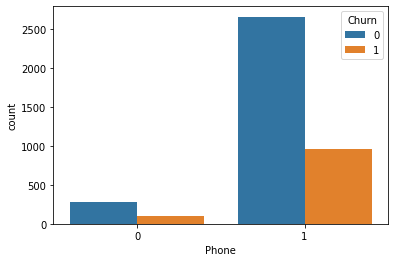

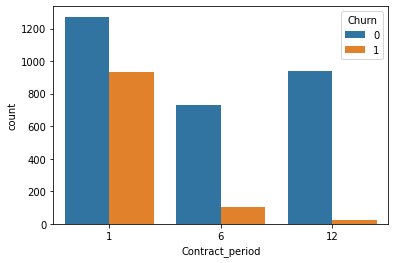

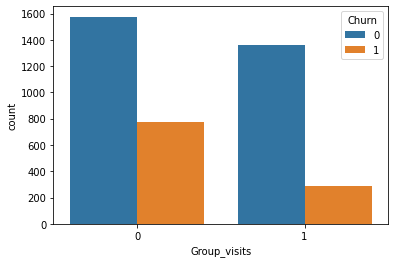

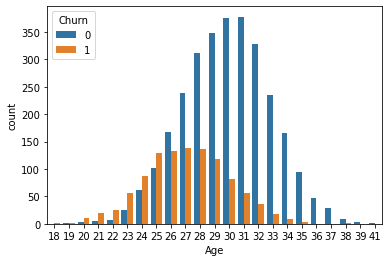

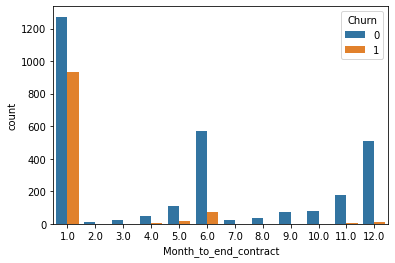

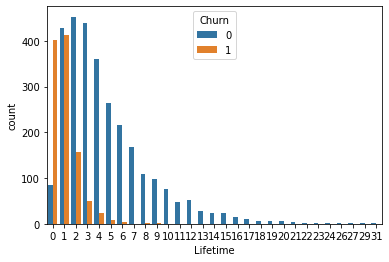

In [10]:
# Для дискретных переменных строим обычные столбчатые диаграммы.
for col in gym_churn.drop(['Churn', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month', 'Avg_additional_charges_total'], axis = 1).columns:
    sns.countplot(data=gym_churn, x=col, hue='Churn')
    plt.show()

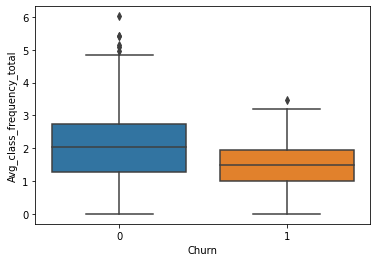

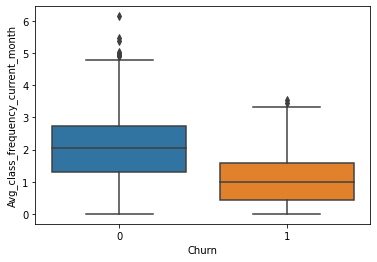

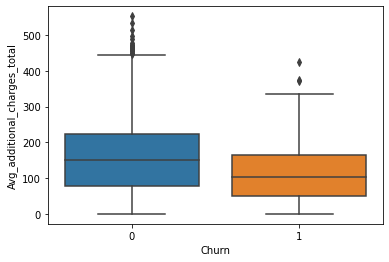

In [11]:
# А для непревывных – боксплот (так мы избежим наложения распределений и отразим именно распределения)
for col in ['Avg_class_frequency_total', 'Avg_class_frequency_current_month', 'Avg_additional_charges_total']:
    sns.boxplot(data=gym_churn, y=col, x='Churn')
    plt.show()

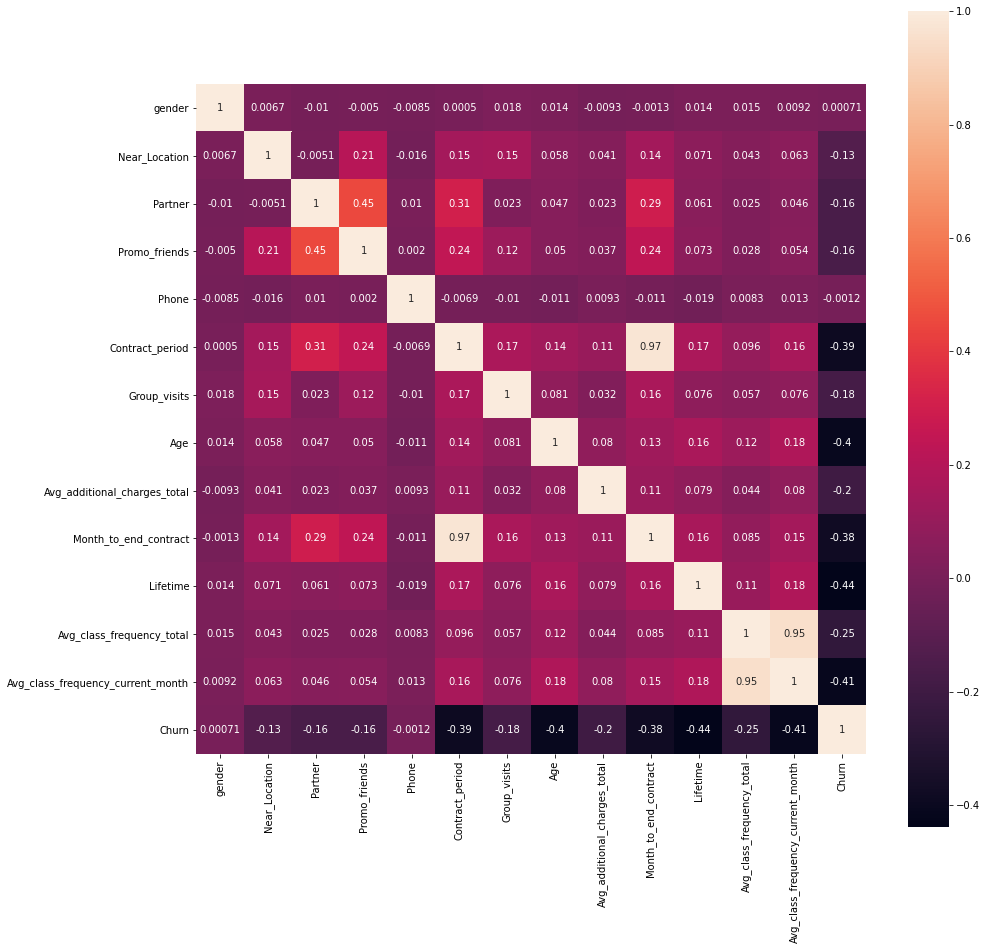

In [12]:
#построим и отрисуем матрицу корреляций
cm = gym_churn.corr()

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)

#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot=True, square=True)
# sns.set(rc={'figure.figsize':(20,18)})
plt.show()

###### Вывод

- отсутствующих признаков нет, все значения заполнены
- дубликатов не обнаружено
- все значения фичей числового типа, нужды в LabelEncoder нет
- проаназилировали базовые метрики на фичах и таргете всего датасета. Видим, что датасет несбалансирован относительно таргета и 0 значительно больше 1 (в 3 раза)
- датасет равномерно распределен относительно пола клиента
- средний возраст 29 лет
- фичи Near_Location и Phone заполнены в большинстве случаев, и, скорее всего, не будут значимы для модели
- построили распределение признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток): видим различия в фичах Avg_additional_charges_total, Avg_class_frequency_total, Avg_class_frequency_current_month
- на матрице корреляция выделяем сильную связь с целевой переменной фичей: Contract_period, Age, Month_to_end_contract, Lifetime, Avg_class_frequency_current_month

## модель прогнозирования оттока клиентов

In [13]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [14]:
# посмотрим, как соотносятся классы для нашего набора данных
gym_churn['Churn'].value_counts()

0    2939
1    1061
Name: Churn, dtype: int64

In [15]:
X = gym_churn.drop('Churn', axis = 1)
y = gym_churn['Churn']

In [16]:
# обучите StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X)

X_st = scaler.transform(X)

In [17]:
# разделяем модель на обучающую и валидационную выборку
X_train_st, X_test_st, y_train, y_test = train_test_split(
    X_st, y, test_size=0.2, random_state=0
)

In [18]:
# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83
	F1: 0.84
	ROC_AUC: 0.97


In [19]:
# зададим алгоритм для новой модели на основе алгоритма решающего дерева
tree_model = DecisionTreeClassifier(random_state=0)
# обучим модель решающего дерева
tree_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
tree_predictions = tree_model.predict(X_test_st)
tree_probabilities = tree_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
print_all_metrics(
    y_test,
    tree_predictions,
    tree_probabilities,
    title='Метрики для модели дерева решений:',
)

Метрики для модели дерева решений:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.80
	F1: 0.80
	ROC_AUC: 0.87


In [20]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81
	F1: 0.83
	ROC_AUC: 0.97


###### Вывод

логрег модель показала лучшее качество чем решающие деревья и практически такой же результат как случайный лес

## кластеризация клиентов

In [21]:
# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward') 

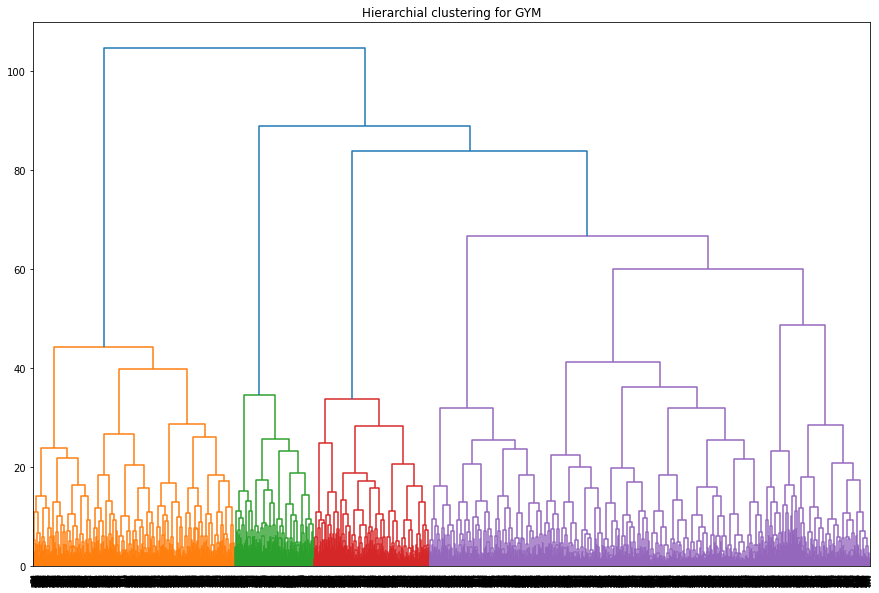

In [22]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show() 

In [23]:
km = KMeans(n_clusters=5, random_state=0) # задаём число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров 

In [24]:
# сохраняем метки кластера в поле нашего датасета
X['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
pd.DataFrame(X.groupby('cluster_km').mean())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
cluster_km,,,,,,,,,,,,,
0,0.50,0.96,0.78,0.57,1.00,10.89,0.54,29.98,160.76,9.95,4.74,1.98,1.97
1,0.52,0.86,0.47,0.31,0.00,4.79,0.43,29.30,143.96,4.48,3.92,1.85,1.72
2,0.50,0.00,0.46,0.08,1.00,2.35,0.22,28.48,135.46,2.20,2.81,1.66,1.48
3,0.49,1.00,0.35,0.24,1.00,1.95,0.34,28.17,131.62,1.86,2.44,1.25,1.01
4,0.56,0.98,0.36,0.23,1.00,2.67,0.47,30.13,161.66,2.46,4.90,2.85,2.85


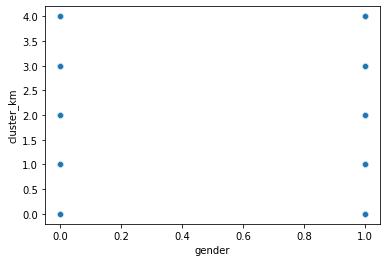

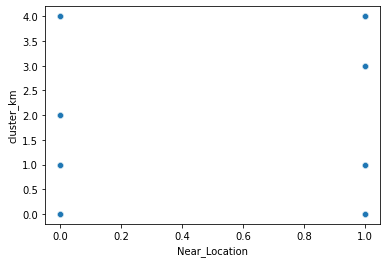

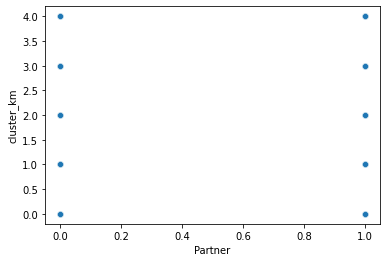

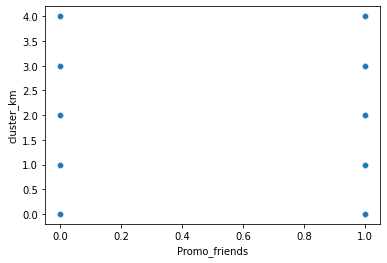

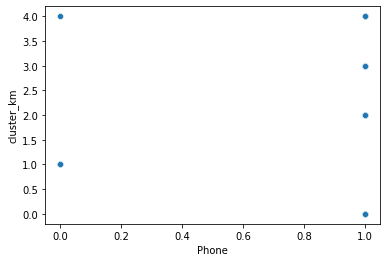

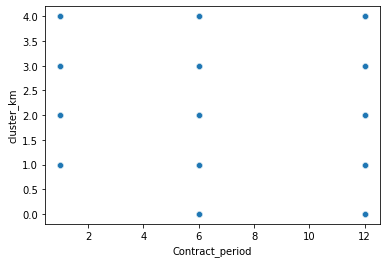

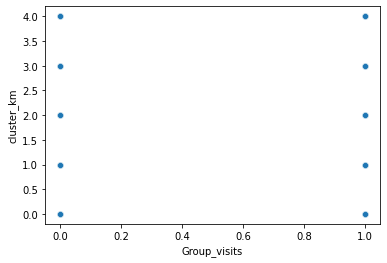

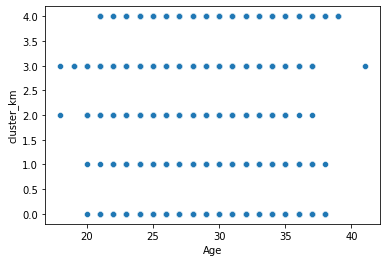

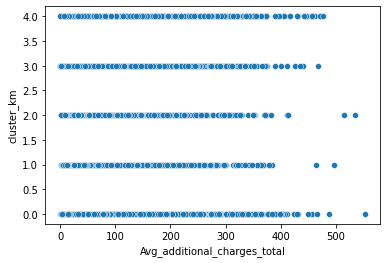

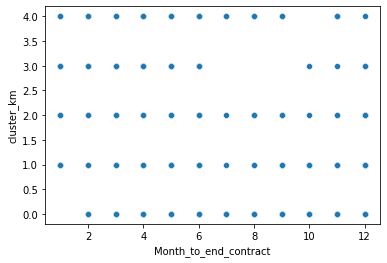

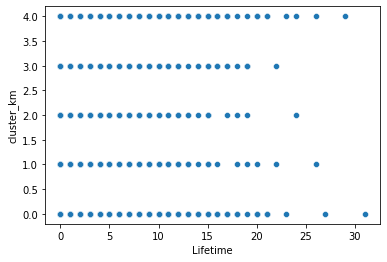

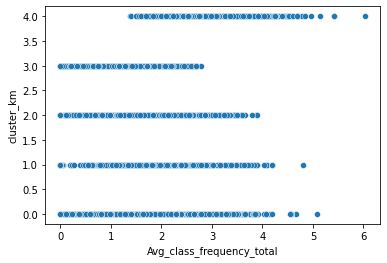

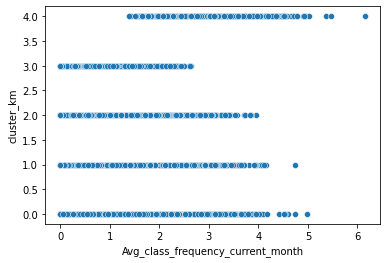

In [25]:
#распределения признаков для кластеров
for col in X.drop('cluster_km', axis = 1).columns:
    sns.scatterplot(x=X[col], y=X['cluster_km'])
    plt.show()

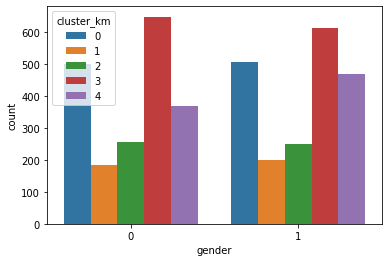

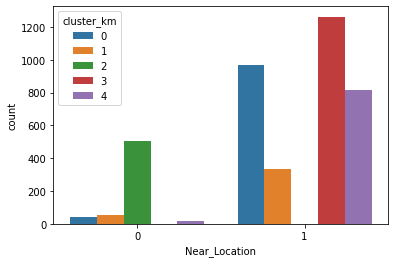

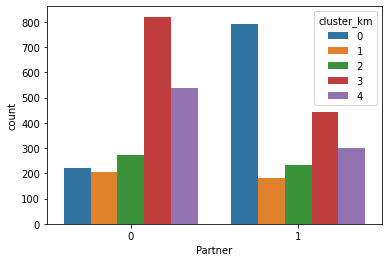

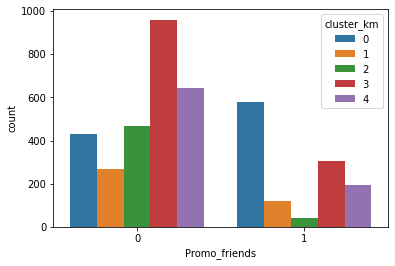

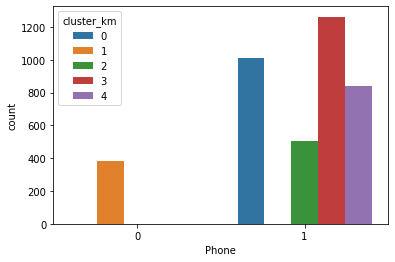

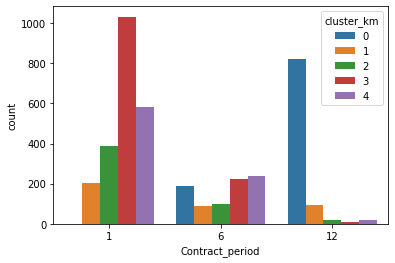

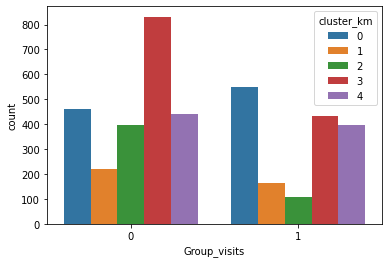

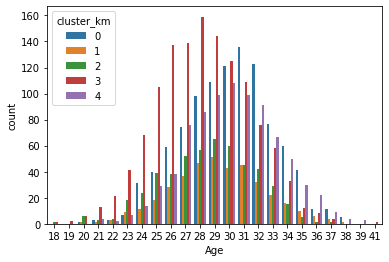

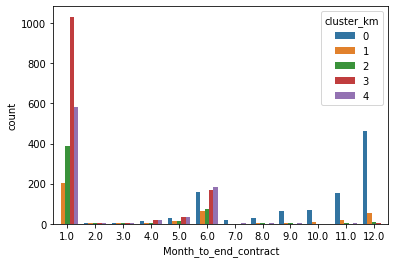

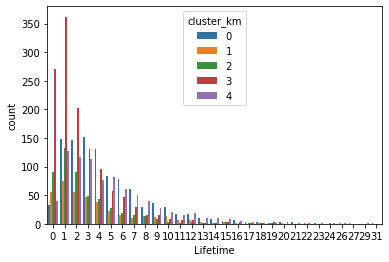

In [26]:
# Для дискретных переменных строим обычные столбчатые диаграммы.
for col in X.drop(['cluster_km', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month', 'Avg_additional_charges_total'], axis = 1).columns:
    sns.countplot(data=X, x=col, hue='cluster_km')
    plt.show()

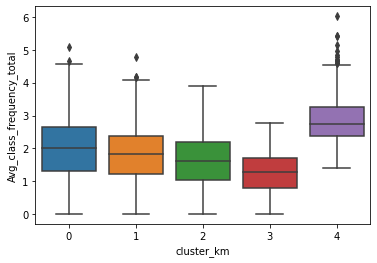

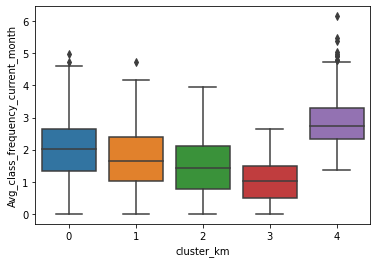

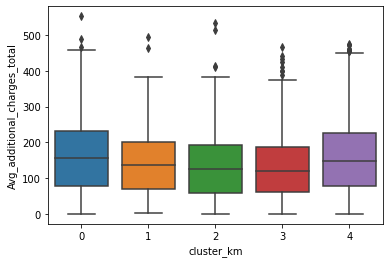

In [27]:
# А для непревывных – боксплот (так мы избежим наложения распределений и отразим именно распределения)
for col in ['Avg_class_frequency_total', 'Avg_class_frequency_current_month', 'Avg_additional_charges_total']:
    sns.boxplot(data=X, y=col, x='cluster_km')
    plt.show()

In [28]:
# доля оттока для кластеров

X_churn = X
X_churn['churn'] = y

X_churn.groupby('cluster_km')['churn'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster_km,,,,,,,,
0,"1,010.00",0.03,0.16,0.00,0.00,0.00,0.00,1.00
1,385.00,0.27,0.44,0.00,0.00,0.00,1.00,1.00
2,505.00,0.44,0.50,0.00,0.00,0.00,1.00,1.00
3,"1,262.00",0.51,0.50,0.00,0.00,1.00,1.00,1.00
4,838.00,0.07,0.25,0.00,0.00,0.00,0.00,1.00


###### вывод

На основе дендрограммы, построенной из матрицы расстояний функцией linkage() на стандартизованной матрице признаков, можно сделать вывод что будет достаточно 4 кластеров

Также обучили модель кластеризации на основании алгоритма K-Means и спрогнозировали кластеры клиентов. По предикту модели можно сделать следующие выводы:
- средние значения признаков для кластеров в целом равномерно распределены, однако выделяется ряд различий:
    - в кластер 2 не попали клиенты с Near_Location
    - в кластер 1 попали все клиенты с незаполненным Phone
    - в кластере 0 сконцентрированы клиенты с максимальными значениями фичей Partner, Promo_friends, Contract_period, Month_to_end_contract

Диаграммы распределения признаков для кластеров также подтверждает вышеобозначенные факты

Кластера отличаются по доле оттока: наибольший отток у кластеров 2-3, наименьшие - 0 и 4. Причем разница оттока между 0 и 3 кластеров более чем в 17 раз

## Вывод

У переменных в исходном датасете были довольно разные по величине стандартные отклонения. Это говорит о том, что их возможно нужно стандартизировать перед обучением, что и было сделано

наименьшим оттоком обладают кластера 0 и 4.

из их распределения фичей можно сделать следующие выводы:
- возраст 20+ чаще остаются в постоянных клиентах, следовательно надо увеличить количество предложений именно на этот сегмент и уменьшить на более младший
- видим, что остаются клиенты, которые стабильно занимаются (фичи Avg_class_frequency_total, Avg_class_frequency_current_month для кластеров 0 и 4 максимальны)

в кластер 2, в котором один из максимальных оттоков, не попали клиенты проживающие или работающие в районе, где находится фитнес-центр. Можно сделать вывод, что надо тратить больше на привлечение клиентов из близлежащих районов.

Конечно, в анализ стоит добавить ряд фичей, таких как нахождение в тц, близость к метро, время работы, наличие бассейна и т.д., что может поспособствовать более качественному расчету модели